# Projet 4 : Anticipez les besoins en consommation de bâtiments

Notebook de prédiction des émissions de Gaz à Effet de Serre

# Sommaire
 - <a href="#C1">Importation des éléments nécessaires</a>
 - <a href="#C2">Fonctions</a>
 - <a href="#C3">Paramètres</a>
 - <a href="#C4">Evaluation des modèles de prédiction</a>
     - <a href="#C4.1">Données sans Energy Star Score</a>
     - <a href="#C4.2">Données avec Energy Star Score</a>
         - <a href="#C4.2.1">Données réelles</a>
         - <a href="#C4.2.2">Données réelles + données prédites</a>

# <a name="C1"> Importation des éléments nécessaires

In [1]:
# Importation des librairies nécessaires
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics

from sklearn import linear_model, kernel_ridge, svm, neighbors
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import plotly.graph_objects as go
import plotly.offline as pyo

# Librairies pour ACP
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn import decomposition
from matplotlib.collections import LineCollection

import datetime

In [2]:
# Importation des données dans un DataFrame
data_final = pd.read_csv('data_final.csv', index_col=0)

In [3]:
# Paramétrer l'affichage des résultats
pd.set_option('display.max_rows',70)
pd.set_option('display.max_columns',70)
pd.options.display.float_format = "{:,.4f}".format

# <a name="C2"> Fonctions

In [4]:
# Fonctions pour passer en NaN les valeurs aberrantes (ici inférieures à 0)
def mistakes(df,var):
    mask_0 = df[var] < 0
    df.loc[mask_0, var] = np.NaN

In [5]:
# Fonction de traitement des outliers en fonction des quartiles
def outliers(df,var):
    # calculer les quartiles
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQ = Q3-Q1
    mini = Q1-1.5*IQ
    maxi = Q3+1.5*IQ
    # mettre les outliers à NaN
    mask_mini = df[var] < mini
    df.loc[mask_mini, var] = np.NaN
    mask_maxi = df[var] > maxi
    df.loc[mask_maxi, var] = np.NaN

In [6]:
# Fonctions pour l'ACP
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# <a name="C3"> Paramètres

In [7]:
# Aperçu des données
data_final.describe()

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,ENERGYSTARScore,Enc_ComplianceStatus,mix_elec,mix_gas,mix_steam,New_PropertyGFATotal,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,Building_Campus,Building_NonResidential,Building_Nonresidential COS,Building_Nonresidential WA,Building_SPS-District K-12,Primary_Distribution Center,Primary_Hospital,Primary_Hotel,Primary_K-12 School,Primary_Laboratory,Primary_Large Office,Primary_Low-Rise Multifamily,Primary_Medical Office,Primary_Mixed Use Property,Primary_Office,Primary_Other,Primary_Refrigerated Warehouse,Primary_Residence Hall,Primary_Restaurant,Primary_Retail Store,Primary_Self-Storage Facility,Primary_Senior Care Community,...,Type_Prison/Incarceration,Type_Refrigerated Warehouse,"Type_Repair Services (Vehicle, Shoe, Locksmith, etc)",Type_Residence Hall/Dormitory,Type_Residential Care Facility,Type_Restaurant,Type_Retail Store,Type_Self-Storage Facility,Type_Senior Care Community,Type_Social/Meeting Hall,Type_Strip Mall,Type_Supermarket/Grocery Store,Type_Urgent Care/Clinic/Other Outpatient,Type_Wholesale Club/Supercenter,Type_Worship Facility,Type_Bar/Nightclub,Type_Data Center,Type_Enclosed Mall,Type_Food Sales,Type_Unknown,Type_Vocational School,Type_Fast Food Restaurant,Neighbor_BALLARD,Neighbor_CENTRAL,Neighbor_DELRIDGE,Neighbor_DOWNTOWN,Neighbor_EAST,Neighbor_GREATER DUWAMISH,Neighbor_LAKE UNION,Neighbor_MAGNOLIA / QUEEN ANNE,Neighbor_NORTH,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST
count,"1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000",...,"1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000"
mean,4.0442,47.6151,-122.3329,"1,959.0416",2.4761,43.8699,0.0642,0.7123,0.2877,0.0000,"56,018.8560",47.6422,0.9513,0.0061,0.8925,0.0416,0.0009,0.0590,0.0434,0.0009,0.0278,0.0902,0.0009,0.0356,0.0017,0.0191,0.0703,0.0026,0.1266,0.0087,0.0147,0.0043,0.0650,0.0243,0.0095,...,0.0026,0.0080,0.0057,0.0145,0.0009,0.0073,0.0753,0.0229,0.0075,0.0057,0.0028,0.0056,0.0009,0.0009,0.0545,0.0003,0.0002,0.0003,0.0003,0.0373,0.0005,0.0000,0.0468,0.0338,0.0330,0.1492,0.0607,0.2611,0.0824,0.0937,0.0434,0.0815,0.0598,0.0304,0.0243
std,2.1418,0.0516,0.0256,32.0522,1.5331,38.4282,0.2452,0.2651,0.2651,0.0000,"40,554.0074",27.1605,0.8460,0.0777,0.3099,0.1998,0.0295,0.2357,0.2038,0.0295,0.1643,0.2866,0.0295,0.1853,0.0416,0.1369,0.2557,0.0510,0.3327,0.0928,0.1206,0.0657,0.2467,0.1540,0.0972,...,0.0510,0.0841,0.0689,0.1158,0.0295,0.0617,0.2283,0.1452,0.0808,0.0666,0.0498,0.0654,0.0295,0.0295,0.2223,0.0071,0.0044,0.0100,0.0088,0.0976,0.0126,0.0015,0.2114,0.1809,0.1786,0.3564,0.2389,0.4394,0.2751,0.2915,0.2038,0.2738,0.2373,0.1716,0.1540
min,1.0000,47.4992,-122.4118,"1,900.0000",0.0000,0.0000,0.0000,0.0045,0.0000,0.0000,"11,285.0000",1.4546,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,47.5753,-122

In [8]:
data_final.head(5)

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,ENERGYSTARScore,Enc_ComplianceStatus,mix_elec,mix_gas,mix_steam,New_PropertyGFATotal,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,Building_Campus,Building_NonResidential,Building_Nonresidential COS,Building_Nonresidential WA,Building_SPS-District K-12,Primary_Distribution Center,Primary_Hospital,Primary_Hotel,Primary_K-12 School,Primary_Laboratory,Primary_Large Office,Primary_Low-Rise Multifamily,Primary_Medical Office,Primary_Mixed Use Property,Primary_Office,Primary_Other,Primary_Refrigerated Warehouse,Primary_Residence Hall,Primary_Restaurant,Primary_Retail Store,Primary_Self-Storage Facility,Primary_Senior Care Community,...,Type_Prison/Incarceration,Type_Refrigerated Warehouse,"Type_Repair Services (Vehicle, Shoe, Locksmith, etc)",Type_Residence Hall/Dormitory,Type_Residential Care Facility,Type_Restaurant,Type_Retail Store,Type_Self-Storage Facility,Type_Senior Care Community,Type_Social/Meeting Hall,Type_Strip Mall,Type_Supermarket/Grocery Store,Type_Urgent Care/Clinic/Other Outpatient,Type_Wholesale Club/Supercenter,Type_Worship Facility,Type_Bar/Nightclub,Type_Data Center,Type_Enclosed Mall,Type_Food Sales,Type_Unknown,Type_Vocational School,Type_Fast Food Restaurant,Neighbor_BALLARD,Neighbor_CENTRAL,Neighbor_DELRIDGE,Neighbor_DOWNTOWN,Neighbor_EAST,Neighbor_GREATER DUWAMISH,Neighbor_LAKE UNION,Neighbor_MAGNOLIA / QUEEN ANNE,Neighbor_NORTH,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST
22,2,47.5458,-122.2685,"1,961.0000",2.0000,95.0000,1,0.6086,0.3914,0.0000,"58,916.0000",29.0859,0.6500,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0,1,0
23,4,47.6596,-122.3175,"2,001.0000",6.0000,84.0000,0,0.6186,0.3814,0.0000,"88,592.0000",41.4618,1.0200,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0
25,7,47.6150,-122.3308,"1,930.0000",2.0000,0.0000,0,1.0000,0.0000,0.0000,"67,224.0000",19.4906,0.1400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,1,0,0,0,0,0,0,0,0,0
29,7,47.6156,-122.3419,"1,978.0000",5.0000,57.0000,0,0.5265,0.4735,0.0000,"68,410.0000",66.6273,1.8800,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2984,0.0000,0.0000,0,0,0,1,0,0,0,0,0,0,0,0,0
32,4,47.6641,-122.3312,"1,906.0000",3.0000,0.0000,0,0.3263,0.6737,0.0000,"87,262.0000",53.9031,1.8100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2734,0.0000,0.0000,0,0,0,0,0,0,1,0,0,0,0,0,0


In [9]:
# colonnes à centrer / réduire  - 'ENERGYSTARScore' exclu
col_std = ['CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 
           'NumberofFloors', 'New_PropertyGFATotal']

# colonnes à centrer / réduire  - 'ENERGYSTARScore' inclu
col_std_2 = ['CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 
           'NumberofFloors', 'ENERGYSTARScore', 'New_PropertyGFATotal']

# colonnes à centrer / réduire pour la prédiction de l'Energy Star
col_std_3 = ['CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors', 
             'New_PropertyGFATotal', 'New_SiteEUIWN(kBtu/sf)', 'New_GHGEmissionsIntensity']

# features X pour la prédiction - 'ENERGYSTARScore' exclu
features_analysis = data_final.columns[~data_final.columns.isin(['New_SiteEUIWN(kBtu/sf)',
                                                                 'New_GHGEmissionsIntensity', 'ENERGYSTARScore'])]

# features X pour la prédiction - 'ENERGYSTARScore' inclu
features_analysis_2 = data_final.columns[~data_final.columns.isin(['New_SiteEUIWN(kBtu/sf)', 'New_GHGEmissionsIntensity'])]

print("Nombre de variables X ('ENERGYSTARScore' exclu) :", len(features_analysis))
print("Nombre de variables X ('ENERGYSTARScore' inclu) :", len(features_analysis_2))

Nombre de variables X ('ENERGYSTARScore' exclu) : 108
Nombre de variables X ('ENERGYSTARScore' inclu) : 109


In [10]:
# Initialisation des modèles et de leurs paramètres

# Paramètres
random = 42
splits = 10
score = 'r2'
tolerance = [0.01]

n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)
Cs = np.logspace(-5, 5, n_alphas)
gammas = np.logspace(-5, 5, n_alphas)

layers = range(20, 30, 5)
iteration = [4000]
estimators = range(500, 700, 100)
l1 = np.arange(0.7, 1, 0.1)
learning_rate = np.arange(0.015, 0.030, 0.005)
kernel = ['rbf']
iter_calc = [8000]

# Modèles à utiliser
ridge = linear_model.Ridge(random_state = random)
lasso = linear_model.Lasso(random_state = random)
net = linear_model.ElasticNet(random_state = random)
krr = kernel_ridge.KernelRidge()
svr = svm.SVR(cache_size = 4000)
rfr = RandomForestRegressor(oob_score=True, random_state = random)
gbr = GradientBoostingRegressor(random_state = random)
mlp = MLPRegressor(random_state = random)

# <a name="C4"> Evaluation des modèles de prédiction

## <a name="C4.1"> Données sans Energy Star Score

In [11]:
# Tests des modèles de prédiction des émissions de GES

# Les données
y = data_final['New_GHGEmissionsIntensity']
X = data_final[features_analysis]

# Ne standardisons que les variables qui en ont besoin
X_std = X.copy()
for col in col_std:
    mean = X[col].mean()
    std = X[col].std()
    X_std[col] = (X[col]-mean) / std
print(X_std.shape)

(1153, 108)


In [12]:
# Algo d'entrainement des modèles
# Titre
print("Modèles de prédiction des émissions des Gaz à Effet de Serre (sans prendre en compte l'Energy Star Score):")
print(70*'-')

# Début des traitements
start = datetime.datetime.now()

# Données
X_train = X_std
y_train = y

# Ridge
params = { 'alpha': alphas, 'tol' : tolerance }
gs_ridge = GridSearchCV(ridge, params, scoring = score, cv=splits)
gs_ridge.fit(X_train, y_train)
print('Ridge :', gs_ridge.best_params_)
init_sum = [('Ridge', round(gs_ridge.best_score_*100,2))]
summary = pd.DataFrame(init_sum, columns = ['Model', 'R2'])

# Lasso
params = { 'alpha': alphas, 'tol' : tolerance , 'max_iter' : iter_calc }
gs_lasso = GridSearchCV(lasso, params, scoring = score, cv=splits)
gs_lasso.fit(X_train, y_train)
print('Lasso :', gs_lasso.best_params_)
summary.loc[1] = ['Lasso', round(gs_lasso.best_score_*100,2)]

# Elastic Net
params = { 'alpha': alphas, 'l1_ratio' : l1, 'tol' : tolerance,  'max_iter' : iter_calc }
gs_net = GridSearchCV(net, params, scoring = score, cv=splits)
gs_net.fit(X_train, y_train)
print('Elastic Net :', gs_net.best_params_)
summary.loc[2] = ['Elastic Net', round(gs_net.best_score_*100,2)]

# Kernel Ridge Regression
params = { 'alpha': alphas, 'gamma' : gammas, 'kernel' : kernel }
gs_krr = GridSearchCV(krr, params, scoring = score, cv=splits)
gs_krr.fit(X_train, y_train)
print('Kernel Ridge Regression :', gs_krr.best_params_)
summary.loc[3] = ['Kernel Ridge Regression', round(gs_krr.best_score_*100,2)]


# Random Forest Regressor
params = {'n_estimators': estimators}
gs_rfr = GridSearchCV(rfr, params, scoring = score, cv=splits)
gs_rfr.fit(X_train, y_train)
print('Random Forest Regressor :', gs_rfr.best_params_)
summary.loc[4] = ['Random Forest Regressor', round(gs_rfr.best_score_*100,2)]

# Gradient Boosting Regressor
params = {'n_estimators': estimators, 'learning_rate': learning_rate}
gs_gbr = GridSearchCV(gbr, params, scoring = score, cv=splits)
gs_gbr.fit(X_train, y_train)
print('Gradient Boosting Regressor :', gs_gbr.best_params_)
summary.loc[5] = ['Gradient Boosting Regressor', round(gs_gbr.best_score_*100,2)]

# Multi-Layer Perceptron Regressor
params = {'hidden_layer_sizes': layers, 'max_iter': iteration, 'alpha': alphas}
gs_mlp = GridSearchCV(mlp, params, scoring = score, cv=splits)
gs_mlp.fit(X_train, y_train)
print('Multi-Layer Perceptron Regressor :', gs_mlp.best_params_)
summary.loc[6] = ['Multi-Layer Perceptron Regressor', round(gs_mlp.best_score_*100,2)]

# Support Vector Regression
params = { 'C': Cs, 'tol' : tolerance, 'kernel' : kernel }
gs_svr = GridSearchCV(svr, params, scoring = score, cv=splits)
gs_svr.fit(X_train, y_train)
print('Support Vector Regression :', gs_svr.best_params_)
summary.loc[7] = ['Support Vector Regression', round(gs_svr.best_score_*100,2)]

# Fin des traitements
end = datetime.datetime.now()
print(70*'-')
print ("Start date and time : ", start.strftime("%Y-%m-%d %H:%M:%S"))
print ("End date and time : ", end.strftime("%Y-%m-%d %H:%M:%S"))

# Trions et affichons les résultats
summary = summary.sort_values(by = 'R2',ascending = False)
summary

Modèles de prédiction des émissions des Gaz à Effet de Serre (sans prendre en compte l'Energy Star Score):
----------------------------------------------------------------------
Ridge : {'alpha': 3.593813663804626, 'tol': 0.01}
Lasso : {'alpha': 0.0016681005372000592, 'max_iter': 8000, 'tol': 0.01}
Elastic Net : {'alpha': 0.0016681005372000592, 'l1_ratio': 0.9999999999999999, 'max_iter': 8000, 'tol': 0.01}
Kernel Ridge Regression : {'alpha': 0.2782559402207126, 'gamma': 0.021544346900318846, 'kernel': 'rbf'}
Random Forest Regressor : {'n_estimators': 600}
Gradient Boosting Regressor : {'learning_rate': 0.02, 'n_estimators': 500}
Multi-Layer Perceptron Regressor : {'alpha': 3.593813663804626, 'hidden_layer_sizes': 20, 'max_iter': 4000}
Support Vector Regression : {'C': 3.593813663804626, 'kernel': 'rbf', 'tol': 0.01}
----------------------------------------------------------------------
Start date and time :  2022-08-31 23:05:01
End date and time :  2022-08-31 23:30:52


,Model,R2
3,Kernel Ridge Regression,56.4700
6,Multi-Layer Perceptron Regressor,56.2000
1,Lasso,55.9200
2,Elastic Net,55.9200
0,Ridge,55.4300
5,Gradient Boosting Regressor,54.5300
7,Support Vector Regression,53.2800
4,Random Forest Regressor,52.8300


In [13]:
# Tentons d'optimiser les hyperparamètres des 2 meilleurs modèles

# Kernel Ridge Regression
# Meilleur paramètre en première analyse : 
# {'alpha': 0.2782559402207126, 'gamma': 0.021544346900318846, 'kernel': 'rbf'}

# nouveaux paramètres
params = { 'alpha': [0.295], 'gamma' : [0.027], 'kernel' : kernel }

gs_krr = GridSearchCV(krr, params, scoring = score, cv=splits)
gs_krr.fit(X_train, y_train)
print('Kernel Ridge Regression')
print('Params :', gs_krr.best_params_)
print('Score :', round(gs_krr.best_score_*100,2))

Kernel Ridge Regression
Params : {'alpha': 0.295, 'gamma': 0.027, 'kernel': 'rbf'}
Score 56.49


In [14]:
# Multi-Layer Perceptron Regressor
# Meilleur paramètre en première analyse : 
# {'alpha': 3.593813663804626, 'hidden_layer_sizes': 20, 'max_iter': 4000}

# nouveaux paramètres
params = {'hidden_layer_sizes': [20], 'max_iter': iteration, 'alpha': [2.5]}

gs_mlp = GridSearchCV(mlp, params, scoring = score, cv=splits)
gs_mlp.fit(X_train, y_train)
print('Multi-Layer Perceptron Regressor')
print('Params :', gs_mlp.best_params_)
print('Score :', round(gs_mlp.best_score_*100,2))

Multi-Layer Perceptron Regressor
Params : {'alpha': 2.5, 'hidden_layer_sizes': 20, 'max_iter': 4000}
Score 57.31


In [15]:
# Regardons pour notre meilleur modèle quelles sont les 10 variables les plus influentes
from sklearn.inspection import permutation_importance
r = permutation_importance(gs_mlp, X_train, y_train, n_repeats=10, random_state=random)
for i in r.importances_mean.argsort()[::-1][:10]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8} : "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

mix_elec : 0.298 +/- 0.013
mix_gas  : 0.293 +/- 0.013
New_PropertyGFATotal : 0.065 +/- 0.010
Type_Non-Refrigerated Warehouse : 0.049 +/- 0.004
YearBuilt : 0.025 +/- 0.003
Type_Worship Facility : 0.015 +/- 0.002
CouncilDistrictCode : 0.013 +/- 0.001
Primary_Worship Facility : 0.011 +/- 0.002
Latitude : 0.010 +/- 0.001
Type_Senior Care Community : 0.007 +/- 0.001


On voit ici que le mix-énergétique (gaz / électricité) a une forte influence sur le résultat. En effet, on peut facilement imaginer qu'un immeuble chauffé au gaz émettra plus de gaz à effet de serre. La surface totale de l'immeuble joue également ainsi que certains types particuliers de surface.

## <a name="C4.2"> Données avec Energy Star Score
### <a name="C4.2.1"> Données réelles

In [16]:
# Reprenons notre jeu de données et retirons les individus dont l'Energy Star Score est à 0 (valeurs absentes)
mask = data_final['ENERGYSTARScore'] != 0
data_energy_star = data_final[mask]
data_energy_star.describe()

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,ENERGYSTARScore,Enc_ComplianceStatus,mix_elec,mix_gas,mix_steam,New_PropertyGFATotal,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,Building_Campus,Building_NonResidential,Building_Nonresidential COS,Building_Nonresidential WA,Building_SPS-District K-12,Primary_Distribution Center,Primary_Hospital,Primary_Hotel,Primary_K-12 School,Primary_Laboratory,Primary_Large Office,Primary_Low-Rise Multifamily,Primary_Medical Office,Primary_Mixed Use Property,Primary_Office,Primary_Other,Primary_Refrigerated Warehouse,Primary_Residence Hall,Primary_Restaurant,Primary_Retail Store,Primary_Self-Storage Facility,Primary_Senior Care Community,...,Type_Prison/Incarceration,Type_Refrigerated Warehouse,"Type_Repair Services (Vehicle, Shoe, Locksmith, etc)",Type_Residence Hall/Dormitory,Type_Residential Care Facility,Type_Restaurant,Type_Retail Store,Type_Self-Storage Facility,Type_Senior Care Community,Type_Social/Meeting Hall,Type_Strip Mall,Type_Supermarket/Grocery Store,Type_Urgent Care/Clinic/Other Outpatient,Type_Wholesale Club/Supercenter,Type_Worship Facility,Type_Bar/Nightclub,Type_Data Center,Type_Enclosed Mall,Type_Food Sales,Type_Unknown,Type_Vocational School,Type_Fast Food Restaurant,Neighbor_BALLARD,Neighbor_CENTRAL,Neighbor_DELRIDGE,Neighbor_DOWNTOWN,Neighbor_EAST,Neighbor_GREATER DUWAMISH,Neighbor_LAKE UNION,Neighbor_MAGNOLIA / QUEEN ANNE,Neighbor_NORTH,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST
count,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,...,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000,770.0000
mean,4.0584,47.6147,-122.3328,"1,960.9584",2.5974,65.6909,0.0961,0.7202,0.2798,0.0000,"59,812.8701",45.4887,0.8922,0.0026,0.9013,0.0091,0.0000,0.0870,0.0481,0.0013,0.0416,0.1338,0.0000,0.0532,0.0013,0.0260,0.0221,0.0039,0.0078,0.0065,0.0195,0.0000,0.0818,0.0000,0.0117,...,0.0000,0.0065,0.0000,0.0188,0.0000,0.0015,0.0834,0.0002,0.0103,0.0000,0.0000,0.0067,0.0000,0.0013,0.0764,0.0001,0.0000,0.0000,0.0000,0.0305,0.0000,0.0000,0.0416,0.0325,0.0364,0.1416,0.0519,0.2494,0.0974,0.0948,0.0403,0.0870,0.0649,0.0351,0.0273
std,2.1457,0.0525,0.0260,31.1000,1.6204,27.8729,0.2949,0.2700,0.2700,0.0000,"42,317.2822",24.2285,0.8003,0.0509,0.2985,0.0950,0.0000,0.2820,0.2140,0.0360,0.1997,0.3406,0.0000,0.2247,0.0360,0.1592,0.1470,0.0623,0.0880,0.0804,0.1383,0.0000,0.2743,0.0000,0.1075,...,0.0000,0.0802,0.0000,0.1337,0.0000,0.0142,0.2517,0.0062,0.0966,0.0011,0.0000,0.0763,0.0000,0.0360,0.2620,0.0021,0.0004,0.0000,0.0000,0.0866,0.0000,0.0000,0.1997,0.1774,0.1873,0.3488,0.2221,0.4329,0.2967,0.2931,0.1967,0.2820,0.2466,0.1841,0.1630
min,1.0000,47.4992,-122.4118,"1,900.0000",0.0000,1.0000,0.0000,0.0045,0.0000,0.0000,"12,294.0000",2.1160,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,47.5735,-122.3455,"1,937.2500",1.0000,50.0000,0.0000,0.5055,0.0000,0.0000,"30,000.0000",29.8806,0.2800,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0

In [17]:
# Tests des modèles de prédiction des émissions de GES

# Les données
y = data_energy_star['New_GHGEmissionsIntensity']
X = data_energy_star[features_analysis_2]

# Ne standardisons que les variables qui en ont besoin (en incluant Energy Star)
X_std = X.copy()
for col in col_std_2:
    mean = X[col].mean()
    std = X[col].std()
    X_std[col] = (X[col]-mean) / std
X_std.shape

(770, 109)

In [18]:
# Algo d'entrainement des modèles
# Titre
print("Modèles de prédiction des émissions des Gaz à Effet de Serre (avec prise en compte l'Energy Star Score):")
print(70*'-')

# Début des traitements
start = datetime.datetime.now()

# Données
X_train = X_std
y_train = y

# Ridge
params = { 'alpha': alphas, 'tol' : tolerance }
gs_ridge = GridSearchCV(ridge, params, scoring = score, cv=splits)
gs_ridge.fit(X_train, y_train)
print('Ridge :', gs_ridge.best_params_)
init_sum = [('Ridge', round(gs_ridge.best_score_*100,2))]
summary = pd.DataFrame(init_sum, columns = ['Model', 'R2'])

# Lasso
params = { 'alpha': alphas, 'tol' : tolerance , 'max_iter' : iter_calc }
gs_lasso = GridSearchCV(lasso, params, scoring = score, cv=splits)
gs_lasso.fit(X_train, y_train)
print('Lasso :', gs_lasso.best_params_)
summary.loc[1] = ['Lasso', round(gs_lasso.best_score_*100,2)]

# Elastic Net
params = { 'alpha': alphas, 'l1_ratio' : l1, 'tol' : tolerance,  'max_iter' : iter_calc }
gs_net = GridSearchCV(net, params, scoring = score, cv=splits)
gs_net.fit(X_train, y_train)
print('Elastic Net :', gs_net.best_params_)
summary.loc[2] = ['Elastic Net', round(gs_net.best_score_*100,2)]

# Kernel Ridge Regression
params = { 'alpha': alphas, 'gamma' : gammas, 'kernel' : kernel }
gs_krr = GridSearchCV(krr, params, scoring = score, cv=splits)
gs_krr.fit(X_train, y_train)
print('Kernel Ridge Regression :', gs_krr.best_params_)
summary.loc[3] = ['Kernel Ridge Regression', round(gs_krr.best_score_*100,2)]


# Random Forest Regressor
params = {'n_estimators': estimators}
gs_rfr = GridSearchCV(rfr, params, scoring = score, cv=splits)
gs_rfr.fit(X_train, y_train)
print('Random Forest Regressor :', gs_rfr.best_params_)
summary.loc[4] = ['Random Forest Regressor', round(gs_rfr.best_score_*100,2)]

# Gradient Boosting Regressor
params = {'n_estimators': estimators, 'learning_rate': learning_rate}
gs_gbr = GridSearchCV(gbr, params, scoring = score, cv=splits)
gs_gbr.fit(X_train, y_train)
print('Gradient Boosting Regressor :', gs_gbr.best_params_)
summary.loc[5] = ['Gradient Boosting Regressor', round(gs_gbr.best_score_*100,2)]

# Multi-Layer Perceptron Regressor
params = {'hidden_layer_sizes': layers, 'max_iter': iteration, 'alpha': alphas}
gs_mlp = GridSearchCV(mlp, params, scoring = score, cv=splits)
gs_mlp.fit(X_train, y_train)
print('Multi-Layer Perceptron Regressor :', gs_mlp.best_params_)
summary.loc[6] = ['Multi-Layer Perceptron Regressor', round(gs_mlp.best_score_*100,2)]

# Support Vector Regression
params = { 'C': Cs, 'tol' : tolerance, 'kernel' : kernel }
gs_svr = GridSearchCV(svr, params, scoring = score, cv=splits)
gs_svr.fit(X_train, y_train)
print('Support Vector Regression :', gs_svr.best_params_)
summary.loc[7] = ['Support Vector Regression', round(gs_svr.best_score_*100,2)]

# Fin des traitements
end = datetime.datetime.now()
print(70*'-')
print ("Start date and time : ", start.strftime("%Y-%m-%d %H:%M:%S"))
print ("End date and time : ", end.strftime("%Y-%m-%d %H:%M:%S"))

# Trions et affichons les résultats
summary = summary.sort_values(by = 'R2',ascending = False)
summary

Modèles de prédiction des émissions des Gaz à Effet de Serre (avec prise en compte l'Energy Star Score):
----------------------------------------------------------------------
Ridge : {'alpha': 3.593813663804626, 'tol': 0.01}
Lasso : {'alpha': 0.0016681005372000592, 'max_iter': 8000, 'tol': 0.01}
Elastic Net : {'alpha': 0.0016681005372000592, 'l1_ratio': 0.7, 'max_iter': 8000, 'tol': 0.01}
Kernel Ridge Regression : {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'}
Random Forest Regressor : {'n_estimators': 500}
Gradient Boosting Regressor : {'learning_rate': 0.02, 'n_estimators': 600}
Multi-Layer Perceptron Regressor : {'alpha': 0.2782559402207126, 'hidden_layer_sizes': 25, 'max_iter': 4000}
Support Vector Regression : {'C': 3.593813663804626, 'kernel': 'rbf', 'tol': 0.01}
----------------------------------------------------------------------
Start date and time :  2022-08-31 23:31:10
End date and time :  2022-08-31 23:43:16


,Model,R2
3,Kernel Ridge Regression,73.2100
5,Gradient Boosting Regressor,72.9400
6,Multi-Layer Perceptron Regressor,72.5800
4,Random Forest Regressor,72.1300
7,Support Vector Regression,70.8200
2,Elastic Net,70.4400
1,Lasso,70.3600
0,Ridge,70.1800


In [19]:
# Tentons d'optimiser les hyperparamètres des 2 meilleurs modèles

# Kernel Ridge Regression
# Meilleur paramètre en première analyse : 
# {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'}

# nouveaux paramètres
params = { 'alpha': [0.028], 'gamma' : [0.016], 'kernel' : kernel }

gs_krr = GridSearchCV(krr, params, scoring = score, cv=splits)
gs_krr.fit(X_train, y_train)
print('Kernel Ridge Regression')
print('Params :', gs_krr.best_params_)
print('Score :', round(gs_krr.best_score_*100,2))

Kernel Ridge Regression
Params : {'alpha': 0.028, 'gamma': 0.016, 'kernel': 'rbf'}
Score : 73.48


In [20]:
# Gradient Boosting Regressor
# Meilleur paramètre en première analyse : 
# {'learning_rate': 0.02, 'n_estimators': 600}

# nouveaux paramètres
params = {'n_estimators': [565], 'learning_rate': [0.028]}

gs_gbr = GridSearchCV(gbr, params, scoring = score, cv=splits)
gs_gbr.fit(X_train, y_train)
print('Gradient Boosting Regressor')
print('Params :', gs_gbr.best_params_)
print('Score :', round(gs_gbr.best_score_*100,2))

Gradient Boosting Regressor
Params : {'learning_rate': 0.028, 'n_estimators': 565}
Score : 73.23


In [21]:
# Regardons pour notre meilleur modèle quelles sont les 10 variables les plus influentes
from sklearn.inspection import permutation_importance
r = permutation_importance(gs_krr, X_train, y_train, n_repeats=10, random_state=random)
for i in r.importances_mean.argsort()[::-1][:10]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8} : "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

mix_gas  : 0.384 +/- 0.017
mix_elec : 0.384 +/- 0.017
ENERGYSTARScore : 0.279 +/- 0.016
Type_Non-Refrigerated Warehouse : 0.046 +/- 0.004
Type_Worship Facility : 0.035 +/- 0.003
YearBuilt : 0.028 +/- 0.005
Type_Senior Care Community : 0.023 +/- 0.002
New_PropertyGFATotal : 0.021 +/- 0.004
CouncilDistrictCode : 0.019 +/- 0.004
NumberofFloors : 0.018 +/- 0.002


### <a name="C4.2.2"> Données réelles + données prédites
Regardons maintenant la performance des modèles si nous prédisons les Energy Star manquants à l'aide d'un knn.

(770, 111)


C:\Users\bruno\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



Knn best params : {'n_neighbors': 7}
Knn best score : 99.84


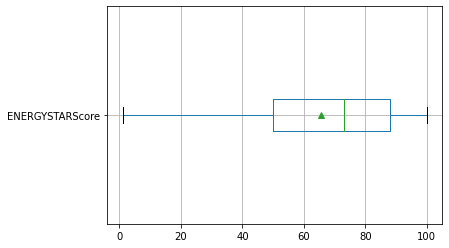

In [22]:
# Entrainons un modèle knn pour prédire l'Energy Star lorsque les valeurs sont manquantes
mask = data_final['ENERGYSTARScore']==0
data_knn = data_final[~mask]
print(data_knn.shape)

X = data_knn.copy()
X.drop('ENERGYSTARScore', axis=1)
y = data_knn['ENERGYSTARScore'].copy()

# Ne standardisons que les variables qui en ont besoin
X_std = X.copy()
for col in col_std_3:
    mean = X[col].mean()
    std = X[col].std()
    X_std[col] = (X[col]-mean) / std

splits = 10

# KNN
knn = neighbors.KNeighborsClassifier()
params = {'n_neighbors' : [5, 7, 11, 15]}
gs_knn = GridSearchCV(knn, params, scoring = score, cv=splits)
gs_knn.fit(X_std, y)
print('Knn best params :', gs_knn.best_params_)
print('Knn best score :', round(gs_knn.best_score_*100,2))

data_knn.boxplot(column='ENERGYSTARScore', vert=False, showfliers= True, showmeans=True)
plt.show()

In [23]:
# Appliquons les prédictions de notre modèle aux valeurs à 0 dans notre jeu de données :
mask = data_final['ENERGYSTARScore'] == 0
data_final.loc[mask, 'ENERGYSTARScore'] = gs_knn.predict(data_final.loc[mask, X_std.columns])

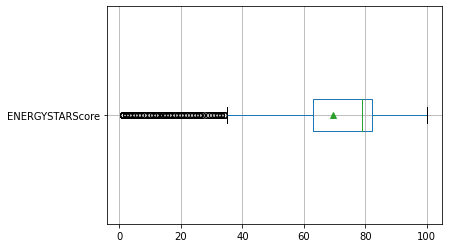

In [24]:
data_final.boxplot(column='ENERGYSTARScore', vert=False, showfliers= True, showmeans=True)
plt.show()

In [25]:
# Tests des modèles de prédiction des émissions de GES

# Les données
y = data_final['New_GHGEmissionsIntensity']
X = data_final[features_analysis_2]

# Ne standardisons que les variables qui en ont besoin
X_std = X.copy()
for col in col_std_2:
    mean = X[col].mean()
    std = X[col].std()
    X_std[col] = (X[col]-mean) / std
X_std.shape

(1153, 109)

In [26]:
# Algo d'entrainement des modèles
# Titre
print("Modèles de prédiction des émissions des Gaz à Effet de Serre (avec Energy Star Score réel et prédit):")
print(70*'-')

# Début des traitements
start = datetime.datetime.now()

# Données
X_train = X_std
y_train = y

# Ridge
params = { 'alpha': alphas, 'tol' : tolerance }
gs_ridge = GridSearchCV(ridge, params, scoring = score, cv=splits)
gs_ridge.fit(X_train, y_train)
print('Ridge :', gs_ridge.best_params_)
init_sum = [('Ridge', round(gs_ridge.best_score_*100,2))]
summary = pd.DataFrame(init_sum, columns = ['Model', 'R2'])

# Lasso
params = { 'alpha': alphas, 'tol' : tolerance , 'max_iter' : iter_calc }
gs_lasso = GridSearchCV(lasso, params, scoring = score, cv=splits)
gs_lasso.fit(X_train, y_train)
print('Lasso :', gs_lasso.best_params_)
summary.loc[1] = ['Lasso', round(gs_lasso.best_score_*100,2)]

# Elastic Net
params = { 'alpha': alphas, 'l1_ratio' : l1, 'tol' : tolerance,  'max_iter' : iter_calc }
gs_net = GridSearchCV(net, params, scoring = score, cv=splits)
gs_net.fit(X_train, y_train)
print('Elastic Net :', gs_net.best_params_)
summary.loc[2] = ['Elastic Net', round(gs_net.best_score_*100,2)]

# Kernel Ridge Regression
params = { 'alpha': alphas, 'gamma' : gammas, 'kernel' : kernel }
gs_krr = GridSearchCV(krr, params, scoring = score, cv=splits)
gs_krr.fit(X_train, y_train)
print('Kernel Ridge Regression :', gs_krr.best_params_)
summary.loc[3] = ['Kernel Ridge Regression', round(gs_krr.best_score_*100,2)]


# Random Forest Regressor
params = {'n_estimators': estimators}
gs_rfr = GridSearchCV(rfr, params, scoring = score, cv=splits)
gs_rfr.fit(X_train, y_train)
print('Random Forest Regressor :', gs_rfr.best_params_)
summary.loc[4] = ['Random Forest Regressor', round(gs_rfr.best_score_*100,2)]

# Gradient Boosting Regressor
params = {'n_estimators': estimators, 'learning_rate': learning_rate}
gs_gbr = GridSearchCV(gbr, params, scoring = score, cv=splits)
gs_gbr.fit(X_train, y_train)
print('Gradient Boosting Regressor :', gs_gbr.best_params_)
summary.loc[5] = ['Gradient Boosting Regressor', round(gs_gbr.best_score_*100,2)]

# Multi-Layer Perceptron Regressor
params = {'hidden_layer_sizes': layers, 'max_iter': iteration, 'alpha': alphas}
gs_mlp = GridSearchCV(mlp, params, scoring = score, cv=splits)
gs_mlp.fit(X_train, y_train)
print('Multi-Layer Perceptron Regressor :', gs_mlp.best_params_)
summary.loc[6] = ['Multi-Layer Perceptron Regressor', round(gs_mlp.best_score_*100,2)]

# Support Vector Regression
params = { 'C': Cs, 'tol' : tolerance, 'kernel' : kernel }
gs_svr = GridSearchCV(svr, params, scoring = score, cv=splits)
gs_svr.fit(X_train, y_train)
print('Support Vector Regression :', gs_svr.best_params_)
summary.loc[7] = ['Support Vector Regression', round(gs_svr.best_score_*100,2)]

# Fin des traitements
end = datetime.datetime.now()
print(70*'-')
print ("Start date and time : ", start.strftime("%Y-%m-%d %H:%M:%S"))
print ("End date and time : ", end.strftime("%Y-%m-%d %H:%M:%S"))

# Trions et affichons les résultats
summary = summary.sort_values(by = 'R2',ascending = False)
summary

Modèles de prédiction des émissions des Gaz à Effet de Serre (avec Energy Star Score réel et prédit):
----------------------------------------------------------------------
Ridge : {'alpha': 3.593813663804626, 'tol': 0.01}
Lasso : {'alpha': 0.0016681005372000592, 'max_iter': 8000, 'tol': 0.01}
Elastic Net : {'alpha': 0.0016681005372000592, 'l1_ratio': 0.9999999999999999, 'max_iter': 8000, 'tol': 0.01}
Kernel Ridge Regression : {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'}
Random Forest Regressor : {'n_estimators': 500}
Gradient Boosting Regressor : {'learning_rate': 0.02, 'n_estimators': 500}
Multi-Layer Perceptron Regressor : {'alpha': 0.2782559402207126, 'hidden_layer_sizes': 25, 'max_iter': 4000}
Support Vector Regression : {'C': 3.593813663804626, 'kernel': 'rbf', 'tol': 0.01}
----------------------------------------------------------------------
Start date and time :  2022-08-31 23:44:13
End date and time :  2022-09-01 00:03:52


,Model,R2
3,Kernel Ridge Regression,63.5200
6,Multi-Layer Perceptron Regressor,62.9700
5,Gradient Boosting Regressor,62.7000
7,Support Vector Regression,62.3500
4,Random Forest Regressor,61.7000
1,Lasso,61.4300
2,Elastic Net,61.4300
0,Ridge,61.2600


In [27]:
# Tentons d'optimiser les hyperparamètres des 2 meilleurs modèles

# Kernel Ridge Regression
# Meilleur paramètre en première analyse : 
# {'alpha': 0.021544346900318846, 'gamma': 0.021544346900318846, 'kernel': 'rbf'}

# nouveaux paramètres
params = { 'alpha': [0.029], 'gamma' : [0.016], 'kernel' : kernel }

gs_krr = GridSearchCV(krr, params, scoring = score, cv=splits)
gs_krr.fit(X_train, y_train)
print('Kernel Ridge Regression')
print('Params :', gs_krr.best_params_)
print('Score :', round(gs_krr.best_score_*100,2))

Kernel Ridge Regression
Params : {'alpha': 0.029, 'gamma': 0.016, 'kernel': 'rbf'}
Score 64.12


In [28]:
# Multi-Layer Perceptron Regressor
# Meilleur paramètre en première analyse : 
# {'alpha': 0.2782559402207126, 'hidden_layer_sizes': 25, 'max_iter': 4000}

# nouveaux paramètres
params = {'hidden_layer_sizes': [25], 'max_iter': iteration, 'alpha': [0.28]}

gs_mlp = GridSearchCV(mlp, params, scoring = score, cv=splits)
gs_mlp.fit(X_train, y_train)
print('Multi-Layer Perceptron Regressor')
print('Params :', gs_mlp.best_params_)
print('Score :', round(gs_mlp.best_score_*100,2))

Multi-Layer Perceptron Regressor
Params : {'alpha': 0.28, 'hidden_layer_sizes': 25, 'max_iter': 4000}
Score 63.41


In [29]:
from sklearn.inspection import permutation_importance
r = permutation_importance(gs_krr, X_train, y_train, n_repeats=10, random_state=random)
for i in r.importances_mean.argsort()[::-1][:10]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8} : "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

mix_gas  : 0.317 +/- 0.012
mix_elec : 0.317 +/- 0.012
ENERGYSTARScore : 0.159 +/- 0.006
Type_Non-Refrigerated Warehouse : 0.153 +/- 0.010
YearBuilt : 0.049 +/- 0.003
New_PropertyGFATotal : 0.048 +/- 0.007
CouncilDistrictCode : 0.033 +/- 0.004
Latitude : 0.031 +/- 0.003
Type_Worship Facility : 0.027 +/- 0.002
NumberofFloors : 0.025 +/- 0.003
